In [1]:
import torch
import numpy as np
import gym
from collections import deque, namedtuple
import random
from matplotlib import pyplot as plt
import numpy as np

In [2]:
tt = torch.tensor
# torch.autograd.set_detect_anomaly(True)

In [3]:
ReplayBufferItem = namedtuple('ReplayBufferItem', ['state', 'action', 'reward', 'next_state', 'done'])
class ReplayBuffer:
    def __init__(self, capacity) -> None:
        self.memory = deque(maxlen=capacity)

    def append(self, *args) -> None:
        self.memory.append(ReplayBufferItem(*args))

    def sample(self, batch_size) -> list:
        return random.sample(self.memory, batch_size)
    
    def sample_reshaped(self, batch_size) -> list:
        # convert list of tuples to tuple of lists
        return zip(*self.sample(batch_size))
    
    def __len__(self) -> int:
        return len(self.memory)

In [4]:
class Critic(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers1, self.layers2 = self._build_network(dims)

    def _build_network(self, dims):
        layers1 = []
        layers2 = []
        for i in range(len(dims)-1):
            layers1.append(torch.nn.Linear(dims[i], dims[i+1]))
            layers2.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers1.append(torch.nn.LeakyReLU())
                layers2.append(torch.nn.LeakyReLU())
        return torch.nn.Sequential(*layers1), torch.nn.Sequential(*layers2)
    
    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        return self.layers1(x), self.layers2(x)

In [5]:
class Actor(torch.nn.Module):
    def __init__(self, dims, high=None, low=None):
        super().__init__()
        self.layers = torch.nn.Sequential()
        
        for i in range(len(dims)-2):
            self.layers.append(torch.nn.Linear(dims[i], dims[i+1]))
            if i != len(dims)-2:
                self.layers.append(torch.nn.LeakyReLU())

        self.mu_layer = torch.nn.Linear(dims[-2], dims[-1])
        self.sigma_layer = torch.nn.Linear(dims[-2], dims[-1])
        
        if high is None or low is None:
            self.action_scale = torch.tensor(1.0)
            self.action_bias = torch.tensor(0.0)
        else:
            self.action_scale = tt((high - low) / 2)
            self.action_bias = tt((high + low) / 2)
            
    def sample(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        action = torch.distributions.Normal(mus, sigmas).sample()
        action = torch.tanh(action) * self.action_scale + self.action_bias
        return action

    def sample_with_log_prob(self, x):
        mus, sigmas = self.forward(x)
        sigmas = torch.exp(sigmas)
        probs = torch.distributions.Normal(mus, sigmas)
        action = probs.rsample()

        # Adjusting for the tanh squashing function
        log_prob = probs.log_prob(action)
        log_prob -= (2 * (np.log(2) - action - torch.nn.functional.softplus(-2 * action)))
        log_prob = log_prob.sum(1, keepdim=True)

        action = torch.tanh(action) * self.action_scale + self.action_bias

        return action, log_prob
    
    def deterministic_action(self, x):
        mus, sigmas = self.forward(x)
        action = torch.tanh(mus) * self.action_scale + self.action_bias
        return action
           
    def forward(self, x):
        mid = self.layers(x)
        mus = self.mu_layer(mid)
        sigmas = self.sigma_layer(mid)
        sigmas = torch.clamp(sigmas, min=-20, max=2)
        return mus, sigmas

In [6]:
class SAC:
    def __init__(self, env, reward_rescaler=None):
        
        input_size = env.observation_space.shape[0]
        output_size = env.action_space.shape[0]
        policy_hidden_dim = [64, 64]
        q_hidden_dim = [64, 64]
        
        self.policy_net_dims = [input_size, *policy_hidden_dim, output_size]
        self.critic_net_dims = [input_size + output_size, *q_hidden_dim, 1]
                
        self.gamma = 0.99
        self.batch_size = 64
        self.steps_to_wait = 512
        self.polyak = 0.995

        self.log_alpha = torch.nn.Parameter(tt(np.log(0.2)))
        self.target_entropy = -torch.prod(tt(env.action_space.shape))
        
        self.env = env
        self.replay_buffer = ReplayBuffer(100000)
        
        self.policy = Actor(self.policy_net_dims, env.action_space.high, env.action_space.low)
        self.critic = Critic(self.critic_net_dims)
        self.critic_t = Critic(self.critic_net_dims)
        
        self.critic_t.load_state_dict(self.critic.state_dict())
        
        self.policy_optimizer = torch.optim.Adam(self.policy.parameters(), lr=1e-4, weight_decay=1e-5)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=1e-4, weight_decay=1e-5)
        self.alpha_optimizer = torch.optim.Adam([self.log_alpha], lr=1e-4)
        
        self.reward_rescaler = reward_rescaler or (lambda x: x)
        
    def train(self, epochs):
        state, info = self.env.reset()
        state = tt(state, dtype=torch.float32)
        r = 0
        scores = []
        losses = []
        for epoch in range(epochs):
            
            # gather experience
            action = self.policy.sample(state)
            next_state, reward, done, trunc, info = self.env.step(action.detach().numpy())
            next_state, reward, done = tt(next_state, dtype=torch.float32), tt(reward, dtype=torch.float32), tt(done)
            r += reward

            reward = self.reward_rescaler(reward)

            self.replay_buffer.append(state, action, reward, next_state, done)
            state = next_state
            
            if len(self.replay_buffer) >= self.steps_to_wait:
                # sample from buffer
                states, actions, rewards, next_states, dones = self.replay_buffer.sample_reshaped(self.batch_size)
                states = torch.stack(states, dim=0)
                actions = torch.stack(actions, dim=0).reshape(-1, 1)
                rewards = torch.stack(rewards, dim=0).reshape(-1, 1)
                next_states = torch.stack(next_states, dim=0)
                dones = torch.stack(dones, dim=0).reshape(-1, 1)

                # update critic
                next_actions, next_log_prob = self.policy.sample_with_log_prob(next_states)
                q1tv, q2tv = self.critic_t(next_states, next_actions)
                target = rewards + self.gamma * (~dones) * torch.min(q1tv, q2tv) - self.log_alpha.exp() * next_log_prob
                target = target.detach()
                                
                q1v, q2v = self.critic(states, actions)
                q1_loss = torch.nn.functional.mse_loss(q1v, target)
                q2_loss = torch.nn.functional.mse_loss(q2v, target)
                
                critic_loss = q1_loss + q2_loss
                
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()
                
                
                # update policy
                now_actions, now_log_prob = self.policy.sample_with_log_prob(next_states)                
                q1v, q2v = self.critic(states, now_actions)
                
                policy_loss = torch.mean(self.log_alpha.exp() * now_log_prob - torch.min(q1v, q2v))
                
                self.policy_optimizer.zero_grad()
                policy_loss.backward()
                self.policy_optimizer.step()
                
                # update alpha
                alpha_loss = torch.mean(self.log_alpha.exp() * (-self.target_entropy - now_log_prob).detach())
                self.alpha_optimizer.zero_grad()
                alpha_loss.backward()
                self.alpha_optimizer.step()
                

                losses.append([q1_loss.item(), q2_loss.item(), policy_loss.item(), alpha_loss.item(), self.log_alpha.exp().item()])
                
                # update target networks using polyak averaging
                for target_param, param in zip(self.critic_t.parameters(), self.critic.parameters()):
                    target_param.data.copy_(target_param.data * (1.0 - self.polyak) + param.data * self.polyak)
                    

            if done or trunc:
                state, info = self.env.reset()
                state = tt(state, dtype=torch.float32)
                print("Step: {}, Reward: {}".format(epoch+1, r))
                scores.append(r)
                r = 0
        
        return scores, losses
            
            

In [7]:
sac = SAC(gym.make('Pendulum-v1'))
scores, losses = sac.train(200 * 200)

d:\Assignment\Year_4\70028\rl\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Step: 200, Reward: -1117.790283203125
Step: 400, Reward: -1049.772216796875
Step: 600, Reward: -1362.2586669921875
Step: 800, Reward: -1655.3018798828125
Step: 1000, Reward: -1739.3682861328125
Step: 1200, Reward: -1631.514892578125
Step: 1400, Reward: -1874.7249755859375
Step: 1600, Reward: -1691.9539794921875
Step: 1800, Reward: -1709.5987548828125
Step: 2000, Reward: -1754.53369140625
Step: 2200, Reward: -1739.53173828125
Step: 2400, Reward: -1914.5831298828125
Step: 2600, Reward: -1697.240478515625
Step: 2800, Reward: -1829.2598876953125
Step: 3000, Reward: -1731.4764404296875
Step: 3200, Reward: -1781.345703125
Step: 3400, Reward: -1684.8179931640625
Step: 3600, Reward: -1688.08935546875
Step: 3800, Reward: -1747.7314453125
Step: 4000, Reward: -1817.2049560546875
Step: 4200, Reward: -1587.844970703125
Step: 4400, Reward: -1650.4970703125
Step: 4600, Reward: -1646.2413330078125
Step: 4800, Reward: -1595.34423828125
Step: 5000, Reward: -1495.10400390625
Step: 5200, Reward: -1812.269

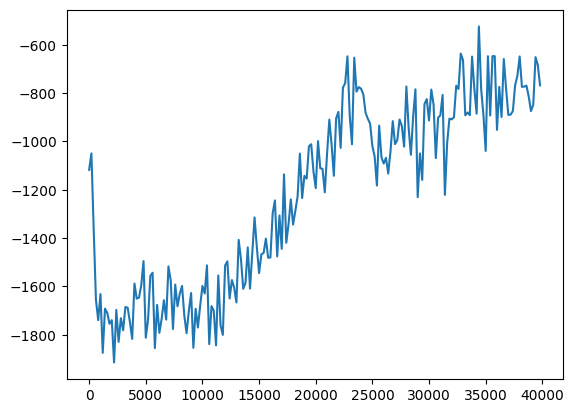

In [8]:
plt.plot(list(range(0, len(scores) * 200, 200)), scores)

In [9]:
trimmed_losses = losses
# trimmed_losses = losses[-5000:]

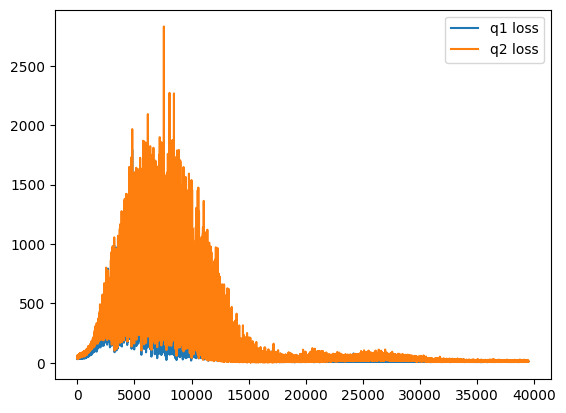

In [10]:
plt.plot(list([l[0], l[1]] for l in trimmed_losses))
plt.legend(['q1 loss', 'q2 loss'])

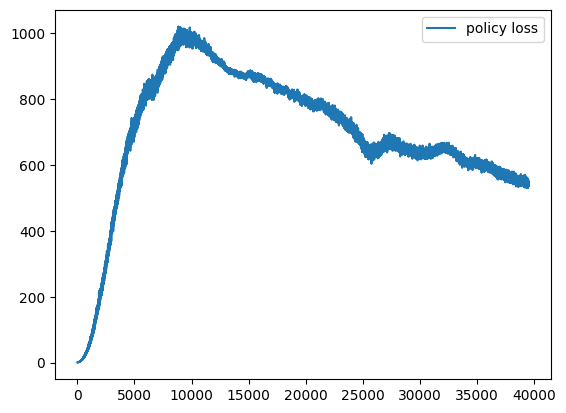

In [11]:
plt.plot([l[2] for l in trimmed_losses])
plt.legend(['policy loss'])

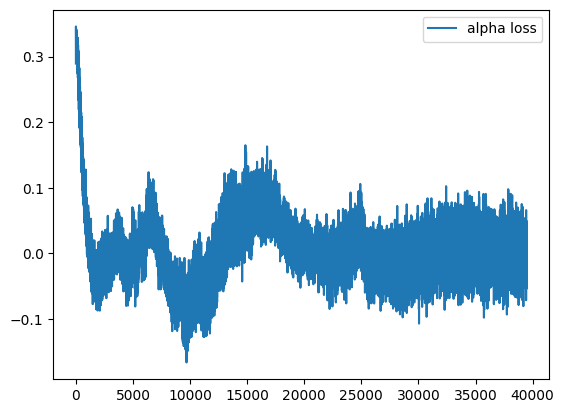

In [12]:
plt.plot([l[3] for l in trimmed_losses])
plt.legend(['alpha loss'])

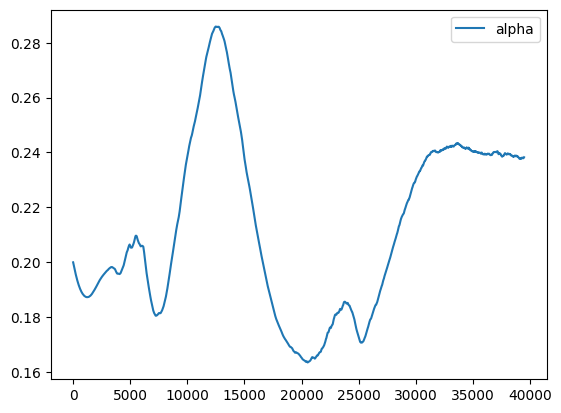

In [13]:
plt.plot([l[4] for l in trimmed_losses])
plt.legend(['alpha'])

In [28]:
import cv2

def capture_episode(env, policy):
    frames = []
    state, info = env.reset()
    done = False
    trunc = False
    while not done and not trunc:
        frames.append(env.render())
        action = policy.sample(torch.tensor(state, dtype=torch.float32)).detach().numpy()
        state, _, done, trunc, info = env.step(action)
    env.close()
    return frames

def save_video(frames, filename='sac_pendulum.mp4', fps=30):
    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video.release()
    
# Usage
env = gym.make('Pendulum-v1', render_mode='rgb_array')
frames = capture_episode(env, sac.policy)
save_video(frames)